# 빅데이터분석(21_2)
### 휴먼지능정보공학과 201810793 이연우
* 9주차 과제
---

3주차 과제에서 데이터를 5천 ~ 1만 건 정도 수집해서 파일로 저장하였다. 내려받은 데이터를 분석하세요.

## 9-1: 문제 설정
- 서울시 코로나19 확진자 현황 
Open_API : http://data.seoul.go.kr/dataList/OA-20279/S/1/datasetView.do

데이터가 무엇인지 생각하게 하는 의문과 문제를 가질 수 있다.
#### 1) 코로나 확진자가 증가하는 추세인가 
#### 2) 지역별로 확진자의 차이가 있는가

의문을 증명가능하도록 분석을 통해 답한다.

## 9-2: 문제의 답

데이터를 분석을 하고 앞서 앞서 제기된 문제에 대해 답을 하자.

- 확진자가 증가하는 추세이면 날짜별로 대여건수가 늘어나는지 분석을 하여 (1) 맞다 또는 (2) 맞지 않다 로 결정할 수 있다. 또한 날짜별 대여건수를 그래프로 시각화하여 보여줄 수도 있다.

- 정량데이터는 describe, groupBy, 통계검증 (anova), 상관관계 등 강의에서 배운 명령어를 활용하여 증명 할 수 있다.

- 정성데이터는 단어빈도를 계산해서, 어떤 단어가 많이 사용되었는지 분석할 수 있다.

In [1]:
# SparkSession 생성
import pyspark
import os

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [2]:
covid = spark.read\
        .option("charset", "euc-kr")\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv(os.path.join('data', '서울시 코로나19 확진자 현황.csv'))

covidDf = covid.select('연번', '확진일', '지역')

In [3]:
covidDf.show()

+------+----------+--------+
|  연번|    확진일|    지역|
+------+----------+--------+
|120240|2021-10-31|동대문구|
|120239|2021-10-31|  구로구|
|120238|2021-10-31|  타시도|
|120237|2021-10-31|  타시도|
|120236|2021-10-31|  구로구|
|120235|2021-10-31|  타시도|
|120234|2021-10-31|동대문구|
|120233|2021-10-31|  강동구|
|120232|2021-10-31|  강서구|
|120231|2021-10-31|  강동구|
|120230|2021-10-31|  강동구|
|120229|2021-10-31|  강동구|
|120228|2021-10-31|  타시도|
|120227|2021-10-31|  서초구|
|120226|2021-10-31|  타시도|
|120225|2021-10-31|  타시도|
|120224|2021-10-31|  관악구|
|120223|2021-10-31|  강동구|
|120222|2021-10-31|  타시도|
|120221|2021-10-31|  타시도|
+------+----------+--------+
only showing top 20 rows



### 문제 1) 코로나 확진자가 증가하는 추세인가 

#### 년-월별 코로나 확진자 수

In [4]:
covidDf = covidDf.withColumn("년월", covidDf.확진일.substr(1, 7))
YMDf = covidDf.groupBy(covidDf.년월).count().sort(covidDf.년월)
YMDf = YMDf.withColumnRenamed('count','확진자 수')

In [5]:
YMDf.toPandas()

,년월,확진자 수
0,2020-01,7
1,2020-02,80
2,2020-03,391
3,2020-04,156
4,2020-05,229
5,2020-06,459
6,2020-07,281
7,2020-08,2415
8,2020-09,1306
9,2020-10,733


#### 년-월별 코로나 확진자 수 그래프

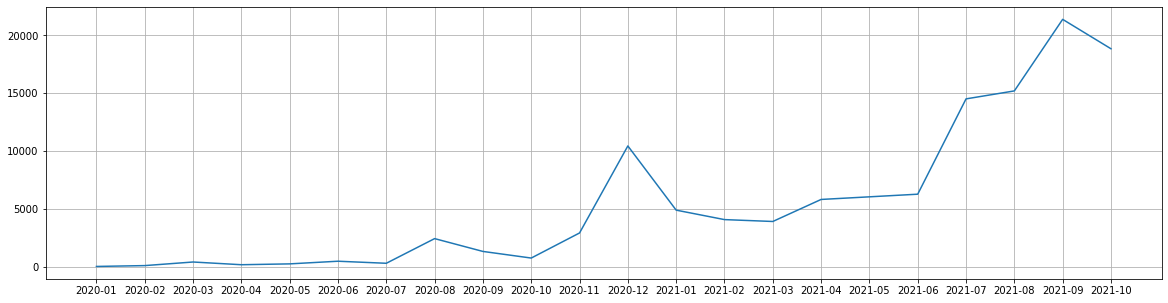

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Date_W = YMDf.rdd.map(lambda fields:fields[0]).collect()
Count_H = YMDf.rdd.map(lambda fields:fields[1]).collect()

plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['axes.grid'] = True

plt.plot(np.array(Date_W), np.array(Count_H))
plt.show()

그래프를 보아 다소 오내림은 있지만 전체적으로 코로나 확진자 수가 증가하고 있다는 것을 볼 수 있다.

### 문제 2) 지역별로 확진자의 차이가 있는가

#### 년-월별 지역별로 확진자의 차이

In [7]:
YMArea = covidDf.groupBy('지역').pivot('년월').count()
YMA_P = YMArea.toPandas().set_index('지역').fillna(0).transpose()
# 결측값 0으로 채우기

In [8]:
YMA_P.head()

지역,송파구,도봉구,은평구,양천구,중랑구,강동구,용산구,구로구,마포구,기타,...,동대문구,동작구,중구,종로구,노원구,서대문구,금천구,성북구,강북구,서초구
2020-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-02,12.0,0.0,7.0,1.0,0.0,4.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,8.0,8.0,4.0,1.0,1.0,0.0,4.0
2020-03,15.0,6.0,14.0,17.0,12.0,6.0,12.0,33.0,16.0,2.0,...,25.0,23.0,5.0,4.0,12.0,9.0,11.0,13.0,5.0,21.0
2020-04,10.0,3.0,7.0,3.0,3.0,3.0,6.0,1.0,7.0,6.0,...,5.0,7.0,1.0,1.0,3.0,6.0,0.0,9.0,0.0,13.0
2020-05,11.0,10.0,7.0,7.0,3.0,11.0,20.0,6.0,3.0,0.0,...,3.0,9.0,3.0,3.0,8.0,8.0,3.0,5.0,9.0,4.0


<AxesSubplot:>

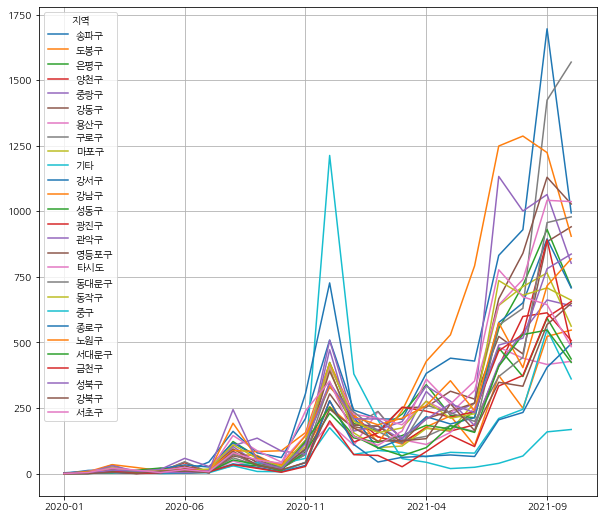

In [9]:
from matplotlib import rc, font_manager
rc('font',family="NanumGothic")
plt.rcParams["figure.figsize"] = (10,9)

YMA_P.plot()

#### 전체 지역별 확진자 수

In [10]:
AreaDf = covidDf.groupBy('지역').count()
AreaDf = AreaDf.withColumnRenamed('count','확진자 수').toPandas().set_index('지역')
AreaDf

,확진자 수
지역,
송파구,7480
도봉구,3197
은평구,5054
양천구,3857
중랑구,4420
강동구,4829
용산구,3176
구로구,5842
마포구,4341


<AxesSubplot:xlabel='지역'>

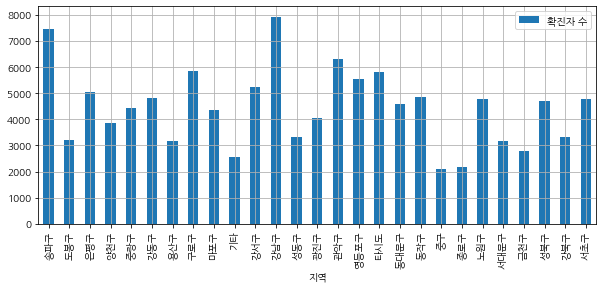

In [11]:
rc('font',family="NanumGothic")
plt.rcParams["figure.figsize"] = (10,4)

AreaDf.plot(kind = 'bar')

막대그래프를 보면 같은 서울이여도 구별로 확진자의 수가 확실이 다르다는 것을 볼 수 있다.